# Overview

Explore relationships between features looking for relationships to use in model fitting.

# Imports and data loading

In [1]:
# Filesystem
from google.colab import drive

# Data manipulation
from datetime import datetime
import pandas as pd
import numpy as np

# Analysis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('Set2')
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(10,5)})

# Model fitting
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
# Load csv
drive.mount('/content/drive', force_remount=True);
path_to_folder = 'drive/My Drive/Colab Notebooks/Fishing/data/'
fish = pd.read_csv(path_to_folder + 'fishing.csv');
fishbd = pd.read_csv(path_to_folder + 'fishing_by_date.csv');

Mounted at /content/drive


# Helper / more cleaning

## Reducing functions

We should have a minimum number of data points for each metric we compute so that any interesting patterns we see are much less likely to be mirages. I ended up choosing six points, but if you wanted to have more statistical certainty you could go for ten or more.

When calculating certain values, we need to remember that values are duplicated. Also, oftentimes they are not duplicated, but still represent a single changing value. For example, if we took a naive average of hours spent fishing we would over-count rows with more observations.

Let's make some helper functions for this. When deciding to use these helper functions remember this: Use the naive calculations if you are thinking about individual fish caught, use the weighted calculations (or `fishbd`) if you are thinking about the day.

We will also plotting in a similar manner between each feature, so we can right some re-usable plotting functions.

In [3]:
# Minimum number of datapoints to show a metric
min_size = 6

In [4]:
# If we want weighted sums we can simply use matrix multiplication
def wsum(value, weight='weight', df=fish):
    d = df[value]
    w = df[weight]
    return (d * w).sum()

# # Example
# print("Fish caught:", wsum('caught'))

In [5]:
# Weighted average
def wavg(value, weight='weight', df=fish):
    d = df[value]
    w = df[weight]
    return (d * w).sum() / w.sum()

# # Example
# print("Average air_temp", wavg("air_temp"))

In [6]:
# Weighted average for groupby.apply()
def wavg_func(value, weight='weight'):
    def wavg(group):
        d = group[value]
        w = group['weight']
        return (d * w).sum() / w.sum()
    return wavg

# # Example
# fish.groupby(['year', 'location']).apply(wavg_func('hook_rate'))

In [7]:
# Return a grouped and reduced dataframe where each group is a minimum size
def reduce_by(by, target=None, reducer='mean', data=fishbd, min_size=min_size,):
    size_mask = data.groupby(by).size() >= min_size
    if reducer == 'mean':
        grouped = data.groupby(by)[target].mean()
    elif reducer == 'size':
        grouped = data.groupby(by).size()
    grouped = grouped[size_mask].reset_index()
    return grouped

## Ordering lists

In [8]:
wind_order = [
    'North', 
    'NorthEast', 
    'East',
    'SouthEast', 
    'South', 
    'SouthWest', 
    'West', 
    'NorthWest' 
]

fish_order = [
    'Lake Trout', 
    'Coho', 
    'Steelhead', 
    'Chinook', 
    'Other'
]

## Controlling for crew count

Let's check whether or not `crew_count` is actually significantly effecting `hook_rate`.

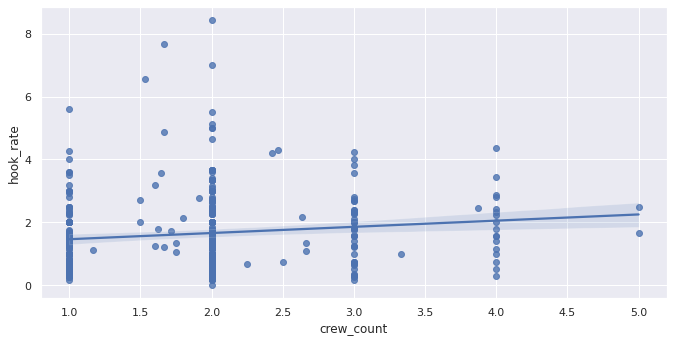

In [9]:
sns.regplot(data=fishbd[['hook_rate','crew_count']], 
            y='hook_rate', x='crew_count');

There isn't a clear relationship between `hook_rate` and `crew_count`, but we can check the correlation and we can further check if it affects the correlations of other variables by controlling for it.

In [10]:
# Calculate hook rate controlled for by crew count
fishbd['hook_rate_ctrl'] = fishbd['hook_rate'] / fishbd['crew_count']

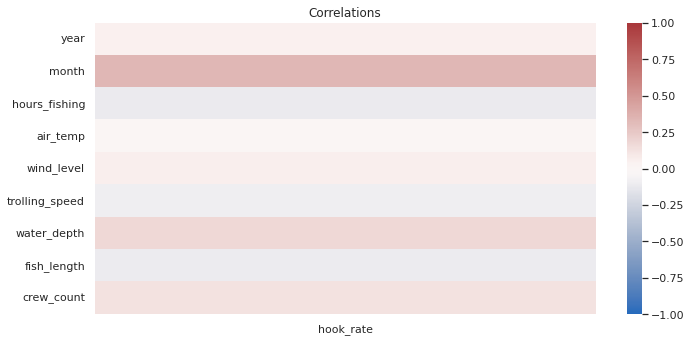

In [11]:
# Besides month and year, crew_count is one of the highest correlations to hook_rate
corr_df= pd.DataFrame(fishbd.corr()['hook_rate']).drop(['hook_rate', 'hook_rate_ctrl', 'caught', 'hooked'])
sns.heatmap(corr_df, vmin=-1, vmax=1, cmap='vlag');
plt.title("Correlations");

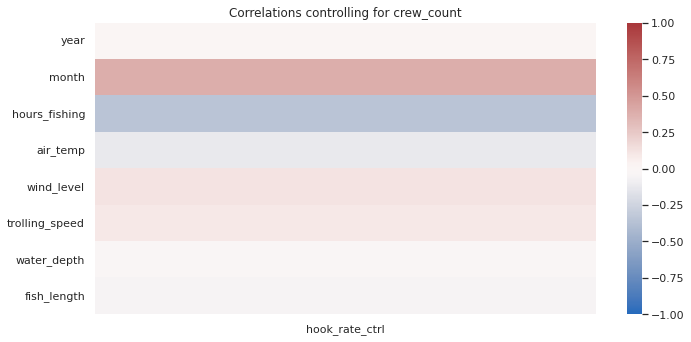

In [12]:
# Correlations for hook rate controlling for crew count
corr_df_ctrl = pd.DataFrame(fishbd.corr()['hook_rate_ctrl']).drop(['crew_count', 'hook_rate', 'hook_rate_ctrl', 'caught', 'hooked'])
sns.heatmap(corr_df_ctrl, vmin=-1, vmax=1, cmap='vlag');
plt.title("Correlations controlling for crew_count");

It seems important to control for `crew_count`. Exactly how to control for it is more ambiguous. Simply dividing `hook_rate` by `crew_count` seems to be a pretty good approach that fits our domain knowledge and knowledge of the dataset (that `crew_count` increase # of rods which increases `hook_rate`).

We can also fit a simple linear model predicting `hook_rate` using `crew_count` to come up with a more nuanced answer. The slope of the model tells us how adding a single crew member affects the `hook_rate`, and the slope + the intercept gives us the prediction of the model. The prediction of the model can be used to control for `crew_count` by dividing the `hook_rate` by it. 

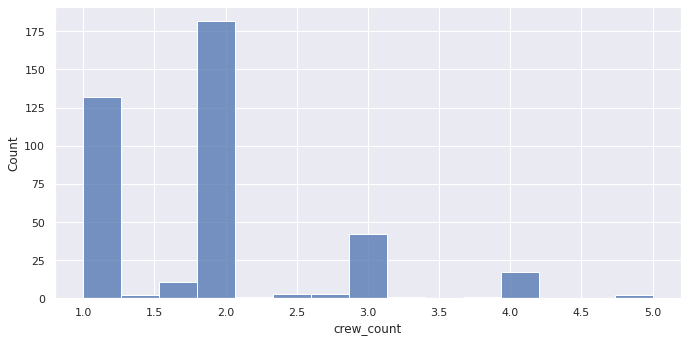

In [13]:
# The non-integer crew counts are a result of days with multiple fishing trips
# (which we ignored for the sake of simplicity)
sns.histplot(fishbd['crew_count']);

In [14]:
# Fit a simple linear model using crew_count and hook_rate
X = fishbd['crew_count']
y = fishbd['hook_rate']
lm = LinearRegression()
lm.fit(fishbd[['crew_count']], fishbd['hook_rate'])
print("Slope:\t\t", lm.coef_[0])
print("Intercept:\t", lm.intercept_)

Slope:		 0.19734954495663856
Intercept:	 1.2623066665134317


In [15]:
# Change hook_rate_ctrl to our new version
fishbd['hook_rate_ctrl'] = fishbd['hook_rate'] / \
    (fishbd['crew_count'] * lm.coef_[0] + lm.intercept_)

Our new controlled hook rate makes a little more sense than before. Adding a new crew member doesn't guarentee that the number of rods increases, and in fact, there is a maximum limit to the number of rods the boat can fit on it. It is not a perfect solution though, as multicollinearity could cause issues. For example, more people will come out to fish in warmer weather, but warmer weather is worse for fishing.

# Exploring data

## Data overview

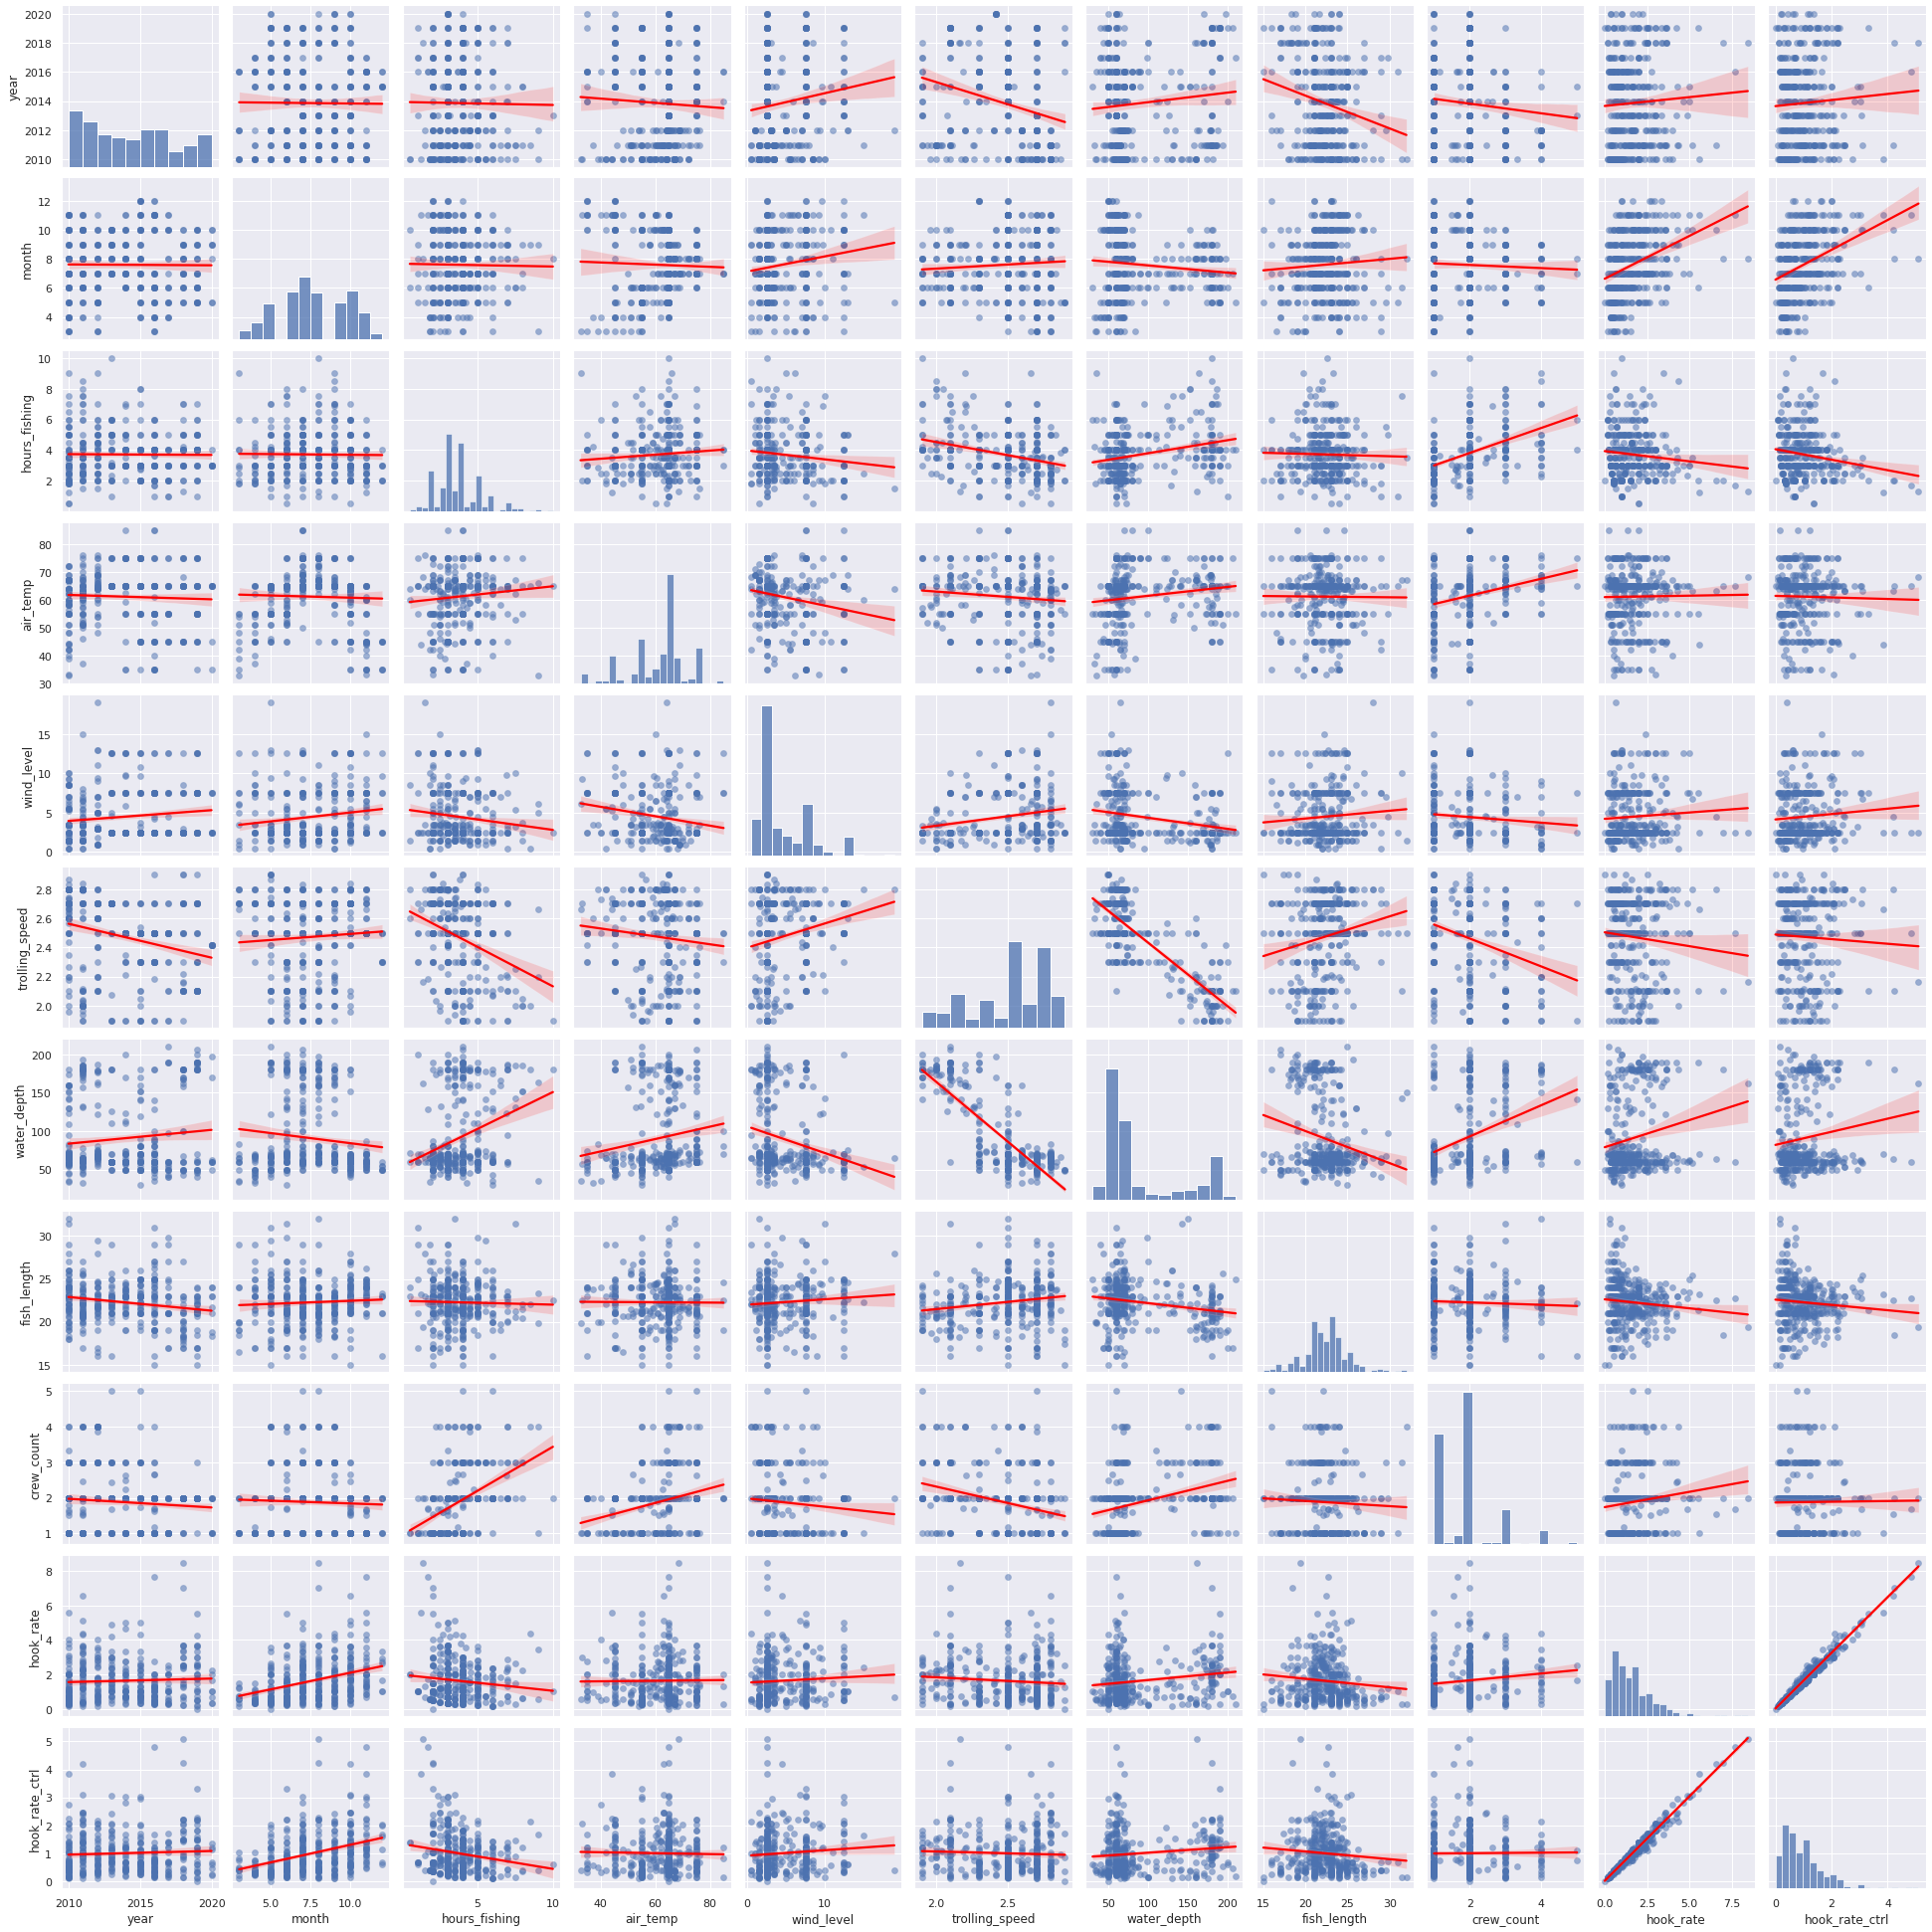

In [ ]:
# Pairplot with a regression plot
g = sns.pairplot(fishbd.drop(columns=['caught', 'hooked']),
                 plot_kws={'alpha': 0.3})
g.map_lower(sns.regplot, 
            scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})
g.map_upper(sns.regplot, 
            scatter_kws={'alpha':0.3}, line_kws={'color': 'red'})

In [ ]:
# # Pairplot with a lowess regression plot
# g = sns.pairplot(fishbd.drop(columns=['caught', 'hooked']),
#                  plot_kws={'alpha': 0.3})
# g.map_upper(sns.regplot, lowess=True, 
#             scatter_kws={'alpha':0.3}, line_kws={'color': 'orange'})
# g.map_lower(sns.regplot, lowess=True, 
#             scatter_kws={'alpha':0.3}, line_kws={'color': 'orange'})

- In some years there are months that are not fished, fx there is no spring fishing.
- `hours_fishing` is negatively correlated with both hook rates. This is because a day with a high `hook_rate` means the fish limit was reached early, meaning less hours are fished. 
- It seems just about every feature is sinusoidally correlated with `month`
- All of the `water_depth` plots seem to have clusters. This is probably because different locations have different water depths. Controlling for `location` seems to be important , we can see that it messes up some of our regplots where there are distinctly two populations.
- `crew_count` seems to be correlated with most of the features

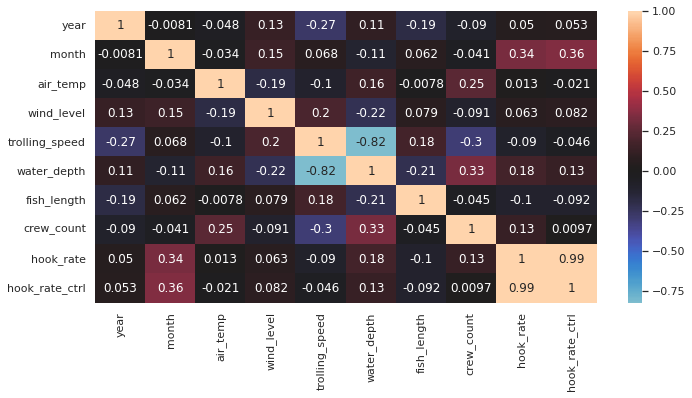

In [ ]:
sns.heatmap(fishbd.drop(columns=['caught', 'hooked', 'hours_fishing']).corr(), 
            center=0, square=False, annot=True)

## Location

Grouping by location gives us a lot of interesting insights into the data. Location is very important when predicting `hook_rate`. We can see how some places are only visited at certain times, for example shot point is only ever really visited in the morning. 

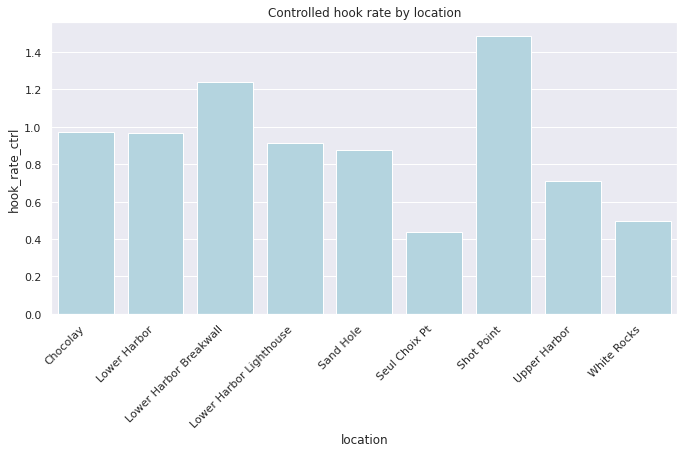

In [17]:
# hook_rate_ctrl by location

hr_loc = reduce_by('location', 'hook_rate_ctrl')

# Plot
sns.barplot(data=hr_loc, x='location', y='hook_rate_ctrl',
            color='lightblue', capsize=.2, errcolor=".5", 
            # linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0)
            )
plt.title("Controlled hook rate by location");
plt.xticks(rotation=45, ha='right');

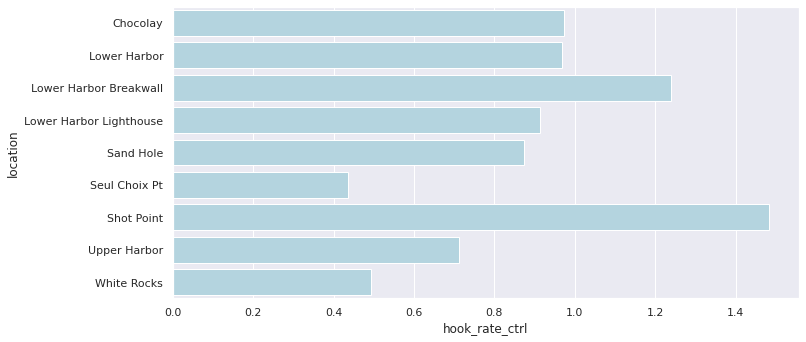

In [19]:
sns.barplot(
    data=hr_loc, x="hook_rate_ctrl", y="location",
    color='lightblue', capsize=.2, errcolor=".5", 
    # linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
);

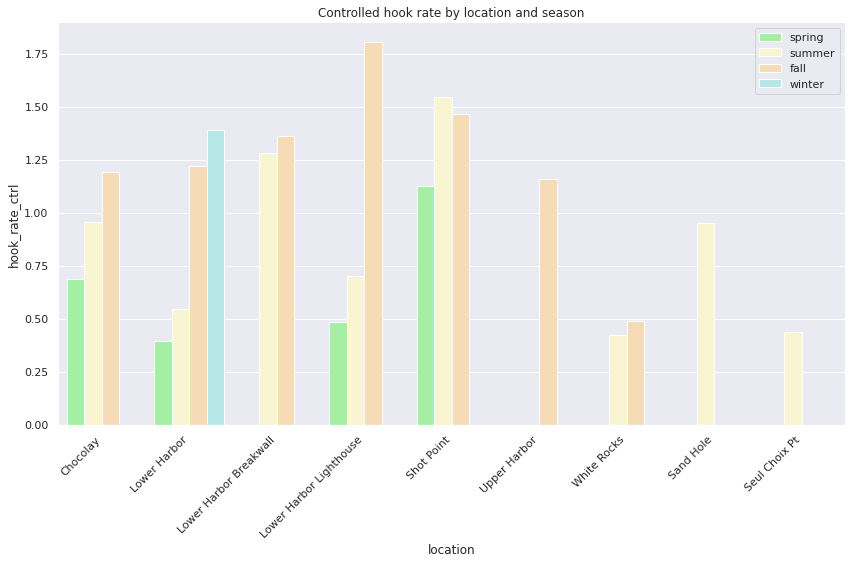

In [ ]:
# hook_rate_ctrl by season and location

hr_szn_loc = reduce_by(['season', 'location'], 'hook_rate_ctrl')

# Plot
g = sns.catplot(data=hr_szn_loc, x='location', y='hook_rate_ctrl', 
                hue='season', kind='bar', legend=False,
                hue_order=['spring', 'summer', 'fall', 'winter'],
                palette=sns.color_palette(['palegreen',
                                           'lemonchiffon',
                                           'navajowhite',
                                           'paleturquoise']));
g.fig.set_size_inches(12, 8);
plt.title("Controlled hook rate by location and season");
plt.legend(loc='upper right')
plt.xticks(rotation=45, ha='right');
plt.tight_layout();

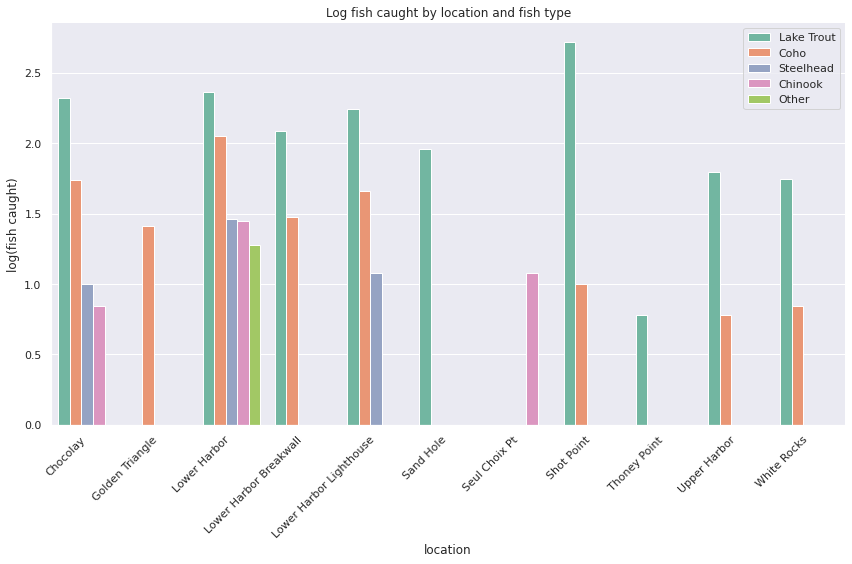

In [ ]:
# fish_type by location

# This plot is a bit sparse and would greatly benefit from reducing the 
# number of locations

ft_loc = reduce_by(['location', 'fish_type'], reducer='size', data=fish)
ft_loc[0] = np.log10(ft_loc[0])

# Plot
g = sns.catplot(data=ft_loc, x='location', y=0, 
                hue='fish_type', kind='bar', legend=False,
                hue_order=fish_order,
                palette=sns.color_palette("Set2"));
g.fig.set_size_inches(12, 8)
plt.title("Log fish caught by location and fish type");
plt.legend(loc='upper right')
plt.ylabel("log(fish caught)");
plt.xticks(rotation=45, ha='right');
plt.tight_layout();

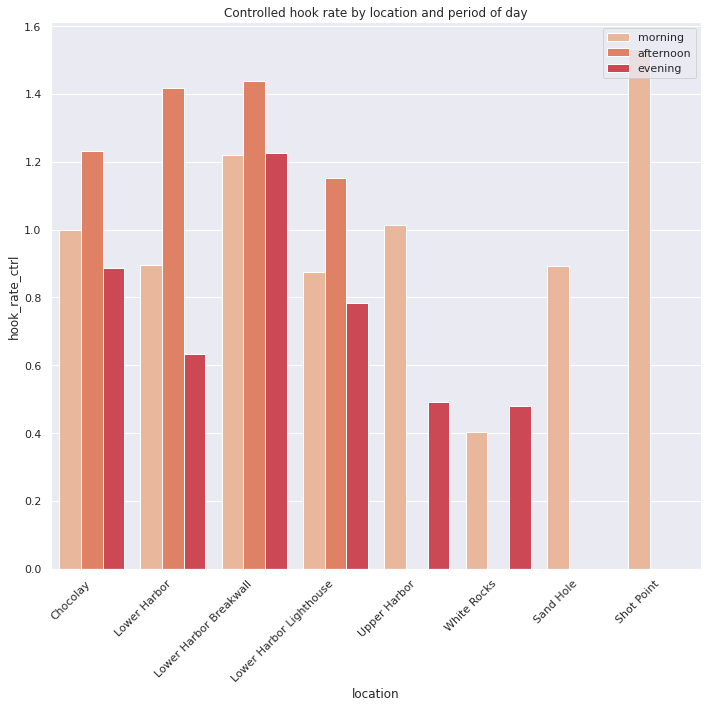

In [ ]:
# hook_rate_ctrl by time_period and location

# If we had data for when the sun rises / sets we could make some more accurate
# plots rather than using the arbitrary time of day. Furthermore we could
# just use a continuous light level instead.

hr_szn_loc = reduce_by(['time_period', 'location'], 'hook_rate_ctrl')

# Plot
g = sns.catplot(data=hr_szn_loc, x='location', y='hook_rate_ctrl', 
                hue='time_period', kind='bar', legend=False,
                palette=sns.color_palette("rocket_r"),
                hue_order=['morning', 'afternoon', 'evening']);
g.fig.set_size_inches(10, 10)
plt.title("Controlled hook rate by location and period of day");
plt.legend(loc='upper right')
plt.xticks(rotation=45, ha='right');
plt.tight_layout();

## Time period

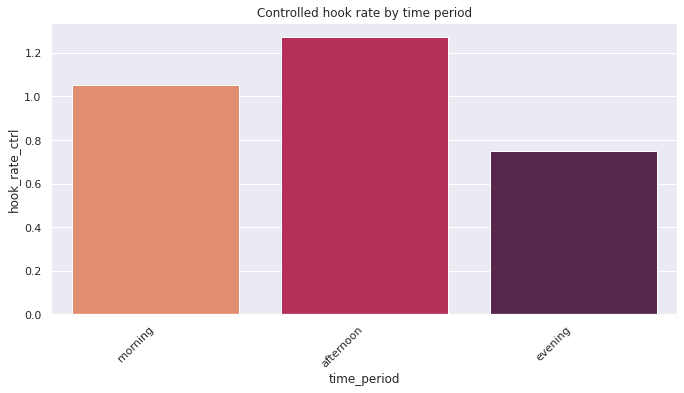

In [ ]:
# hook_rate by time period
hr_tp = reduce_by('time_period', ['time_period', 'hook_rate_ctrl'])

# plot
sns.barplot(data=hr_tp, x='time_period', y='hook_rate_ctrl',
            order=['morning', 'afternoon', 'evening'],
            palette='rocket_r');
plt.title("Controlled hook rate by time period");
plt.xticks(rotation=45, ha='right');

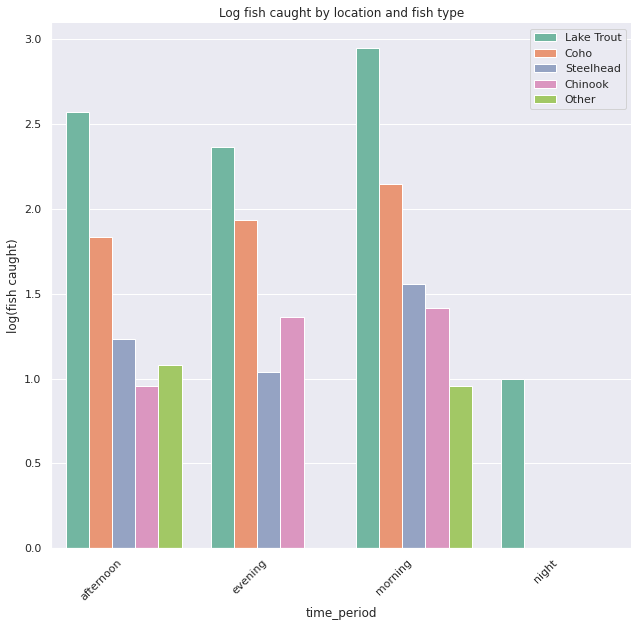

In [ ]:
# fish_type by time period
ft_tp = reduce_by(['time_period', 'fish_type'], reducer='size', data=fish)
ft_tp[0] = np.log10(ft_tp[0])

# plot
g = sns.catplot(data=ft_tp, x='time_period', y=0, 
                hue='fish_type', kind='bar', legend=False,
                hue_order=['Lake Trout', 'Coho', 'Steelhead', 'Chinook', 'Other'],
                palette=sns.color_palette("Set2"));
g.fig.set_size_inches(10, 10)
plt.title("Log fish caught by location and fish type");
plt.ylabel("log(fish caught)");
plt.legend(loc='upper right')
plt.xticks(rotation=45, ha='right');
plt.tight_layout();

## Year

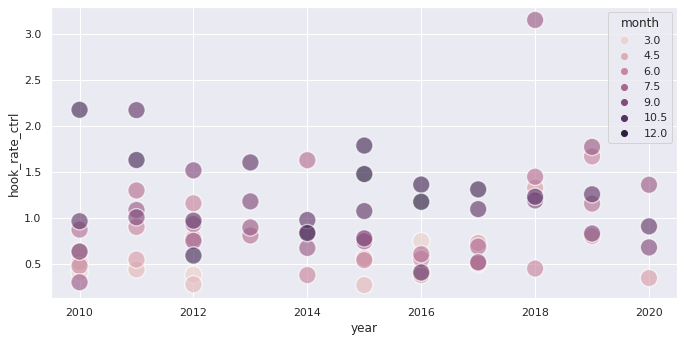

In [80]:
grouped = fishbd.groupby(['year', 'month']).mean()
grouped = grouped.reset_index()
sns.scatterplot(data=grouped, x='year', y='hook_rate_ctrl', hue='month',
                s=300, legend='brief', alpha=0.65);

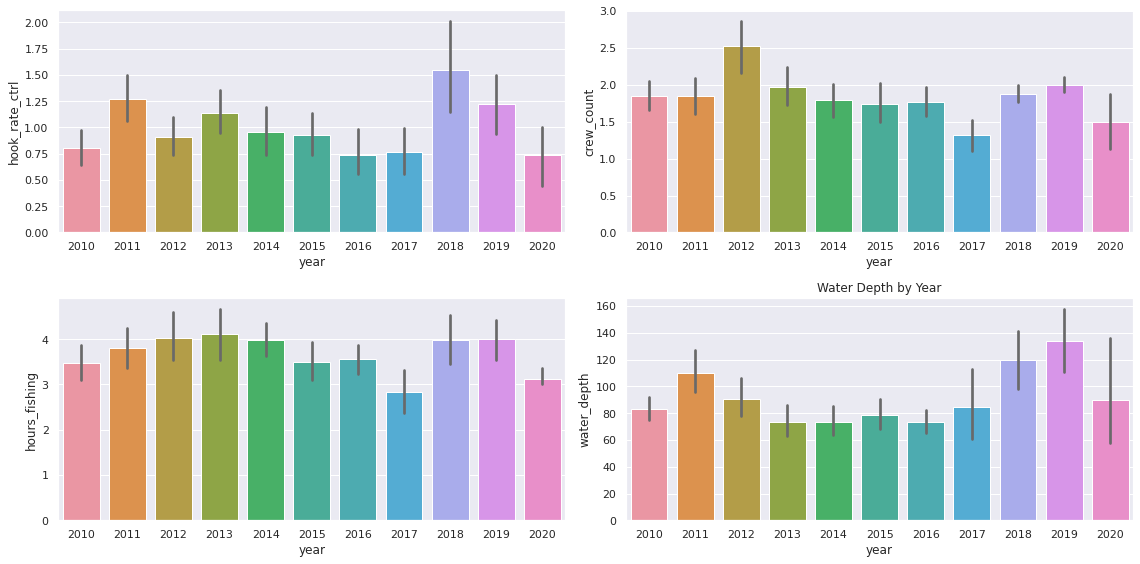

In [70]:
# Plot some exploratory bar charts

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(16, 8)

def plot_by_year(y, title, ax):
    sns.barplot(x=fishbd['year'].astype(int), y=fishbd[y],
            errcolor='dimgrey', ax=ax);
    plt.title(title)

plot_by_year('hook_rate_ctrl', "Hook Rate by Year", ax[0,0])
plot_by_year('crew_count', "Crew Count by Year", ax[0,1])
plot_by_year('hours_fishing', "Hours Fishing by Year", ax[1,0])
plot_by_year('water_depth', "Water Depth by Year", ax[1,1])
plt.tight_layout()


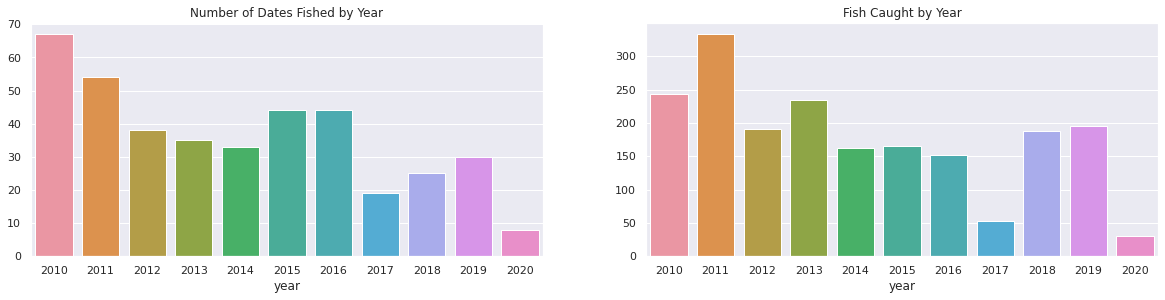

In [83]:
# Plot some counts by year

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 4)

grouped = fishbd.groupby('year').size()
sns.barplot(x=grouped.index.astype(int), y=grouped, ax=ax[0])
ax[0].set_title("Number of Dates Fished by Year")

grouped = fish.groupby('year').size()
sns.barplot(x=grouped.index.astype(int), y=grouped, ax=ax[1])
ax[1].set_title("Fish Caught by Year");

## Affects of a southern wind

This would be much better with continuous data for wind. The radial FacetGrid would be an excellent plot for this type that type of data.

In [90]:
# Sort by wind directions so they are easier to compare
def sort_wind(series):
    sort_dict = {
        'North': 0,
        'NorthEast': 1,
        'East': 2,
        'SouthEast': 3,
        'South': 4,
        'SouthWest': 5,
        'West': 6,
        'NorthWest': 7
    }
    new_series = [sort_dict[val] for val in series]
    return new_series
fishbd.sort_values(by='wind_dir', key=sort_wind, inplace=True)

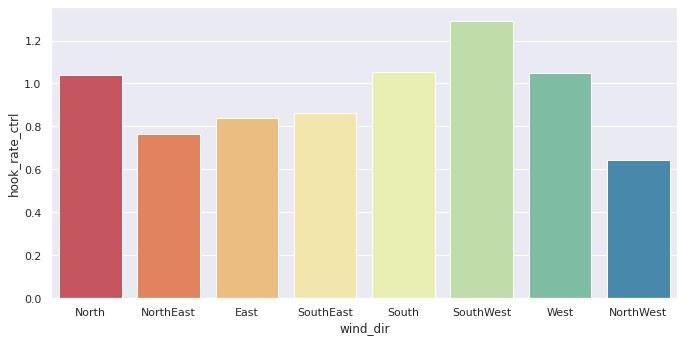

In [91]:
# Hook rate by wind direction
sns.barplot(data=fishbd.groupby(['wind_dir']).mean().reset_index(),
            x='wind_dir',y='hook_rate_ctrl', order=wind_order,
            ci=False, palette='Spectral');

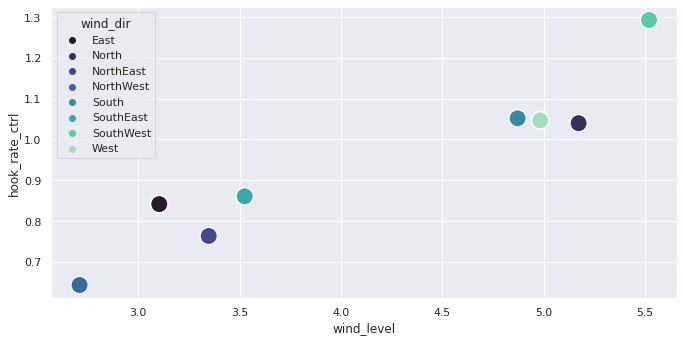

In [92]:
sns.scatterplot(data=fishbd.groupby(['wind_dir']).mean().reset_index(),
                x='wind_level', y='hook_rate_ctrl', hue='wind_dir', s=300,
                palette='mako')

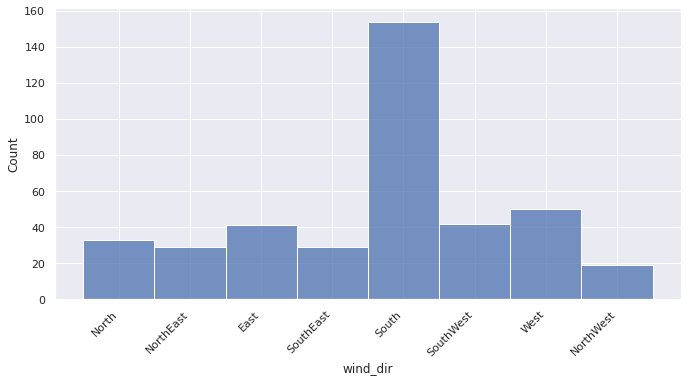

In [95]:
# Histogram of wind direction
sns.histplot(fishbd['wind_dir'])
plt.xticks(rotation=45, ha='right');

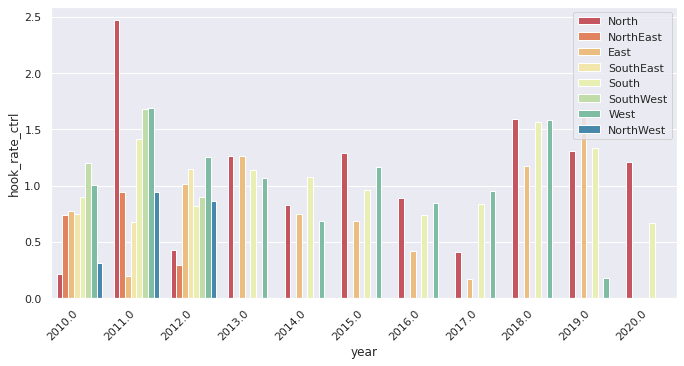

In [ ]:
# Hook rate by year and wind direction
g = sns.barplot(data=fishbd, x='year', y='hook_rate_ctrl', hue='wind_dir', 
                ci=False, palette='Spectral')
plt.xticks(rotation=45, ha='right');
plt.legend(loc='upper right')

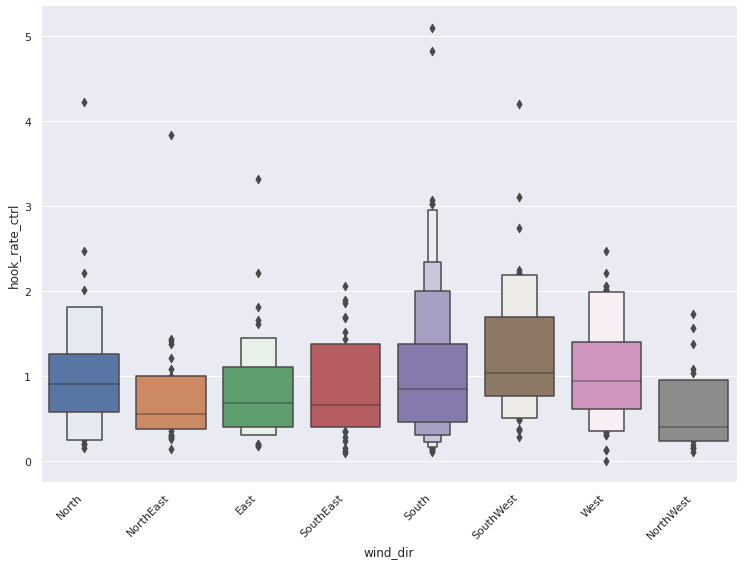

In [ ]:
g = sns.catplot(data=fishbd, x='wind_dir', y='hook_rate_ctrl', kind='boxen')
g.fig.set_size_inches(12, 8)
plt.xticks(rotation=45, ha='right');

## Water depth when controlling for location

We see that Shot Point and White Rocks are at significantly different deeper compared to the other locations. From our plot of the smaller sampled locations we can see Upper Harbor and Sand Hole are also deeper. 

It is interesting to see the relationship between `trolling_speed` and `water_depth`.

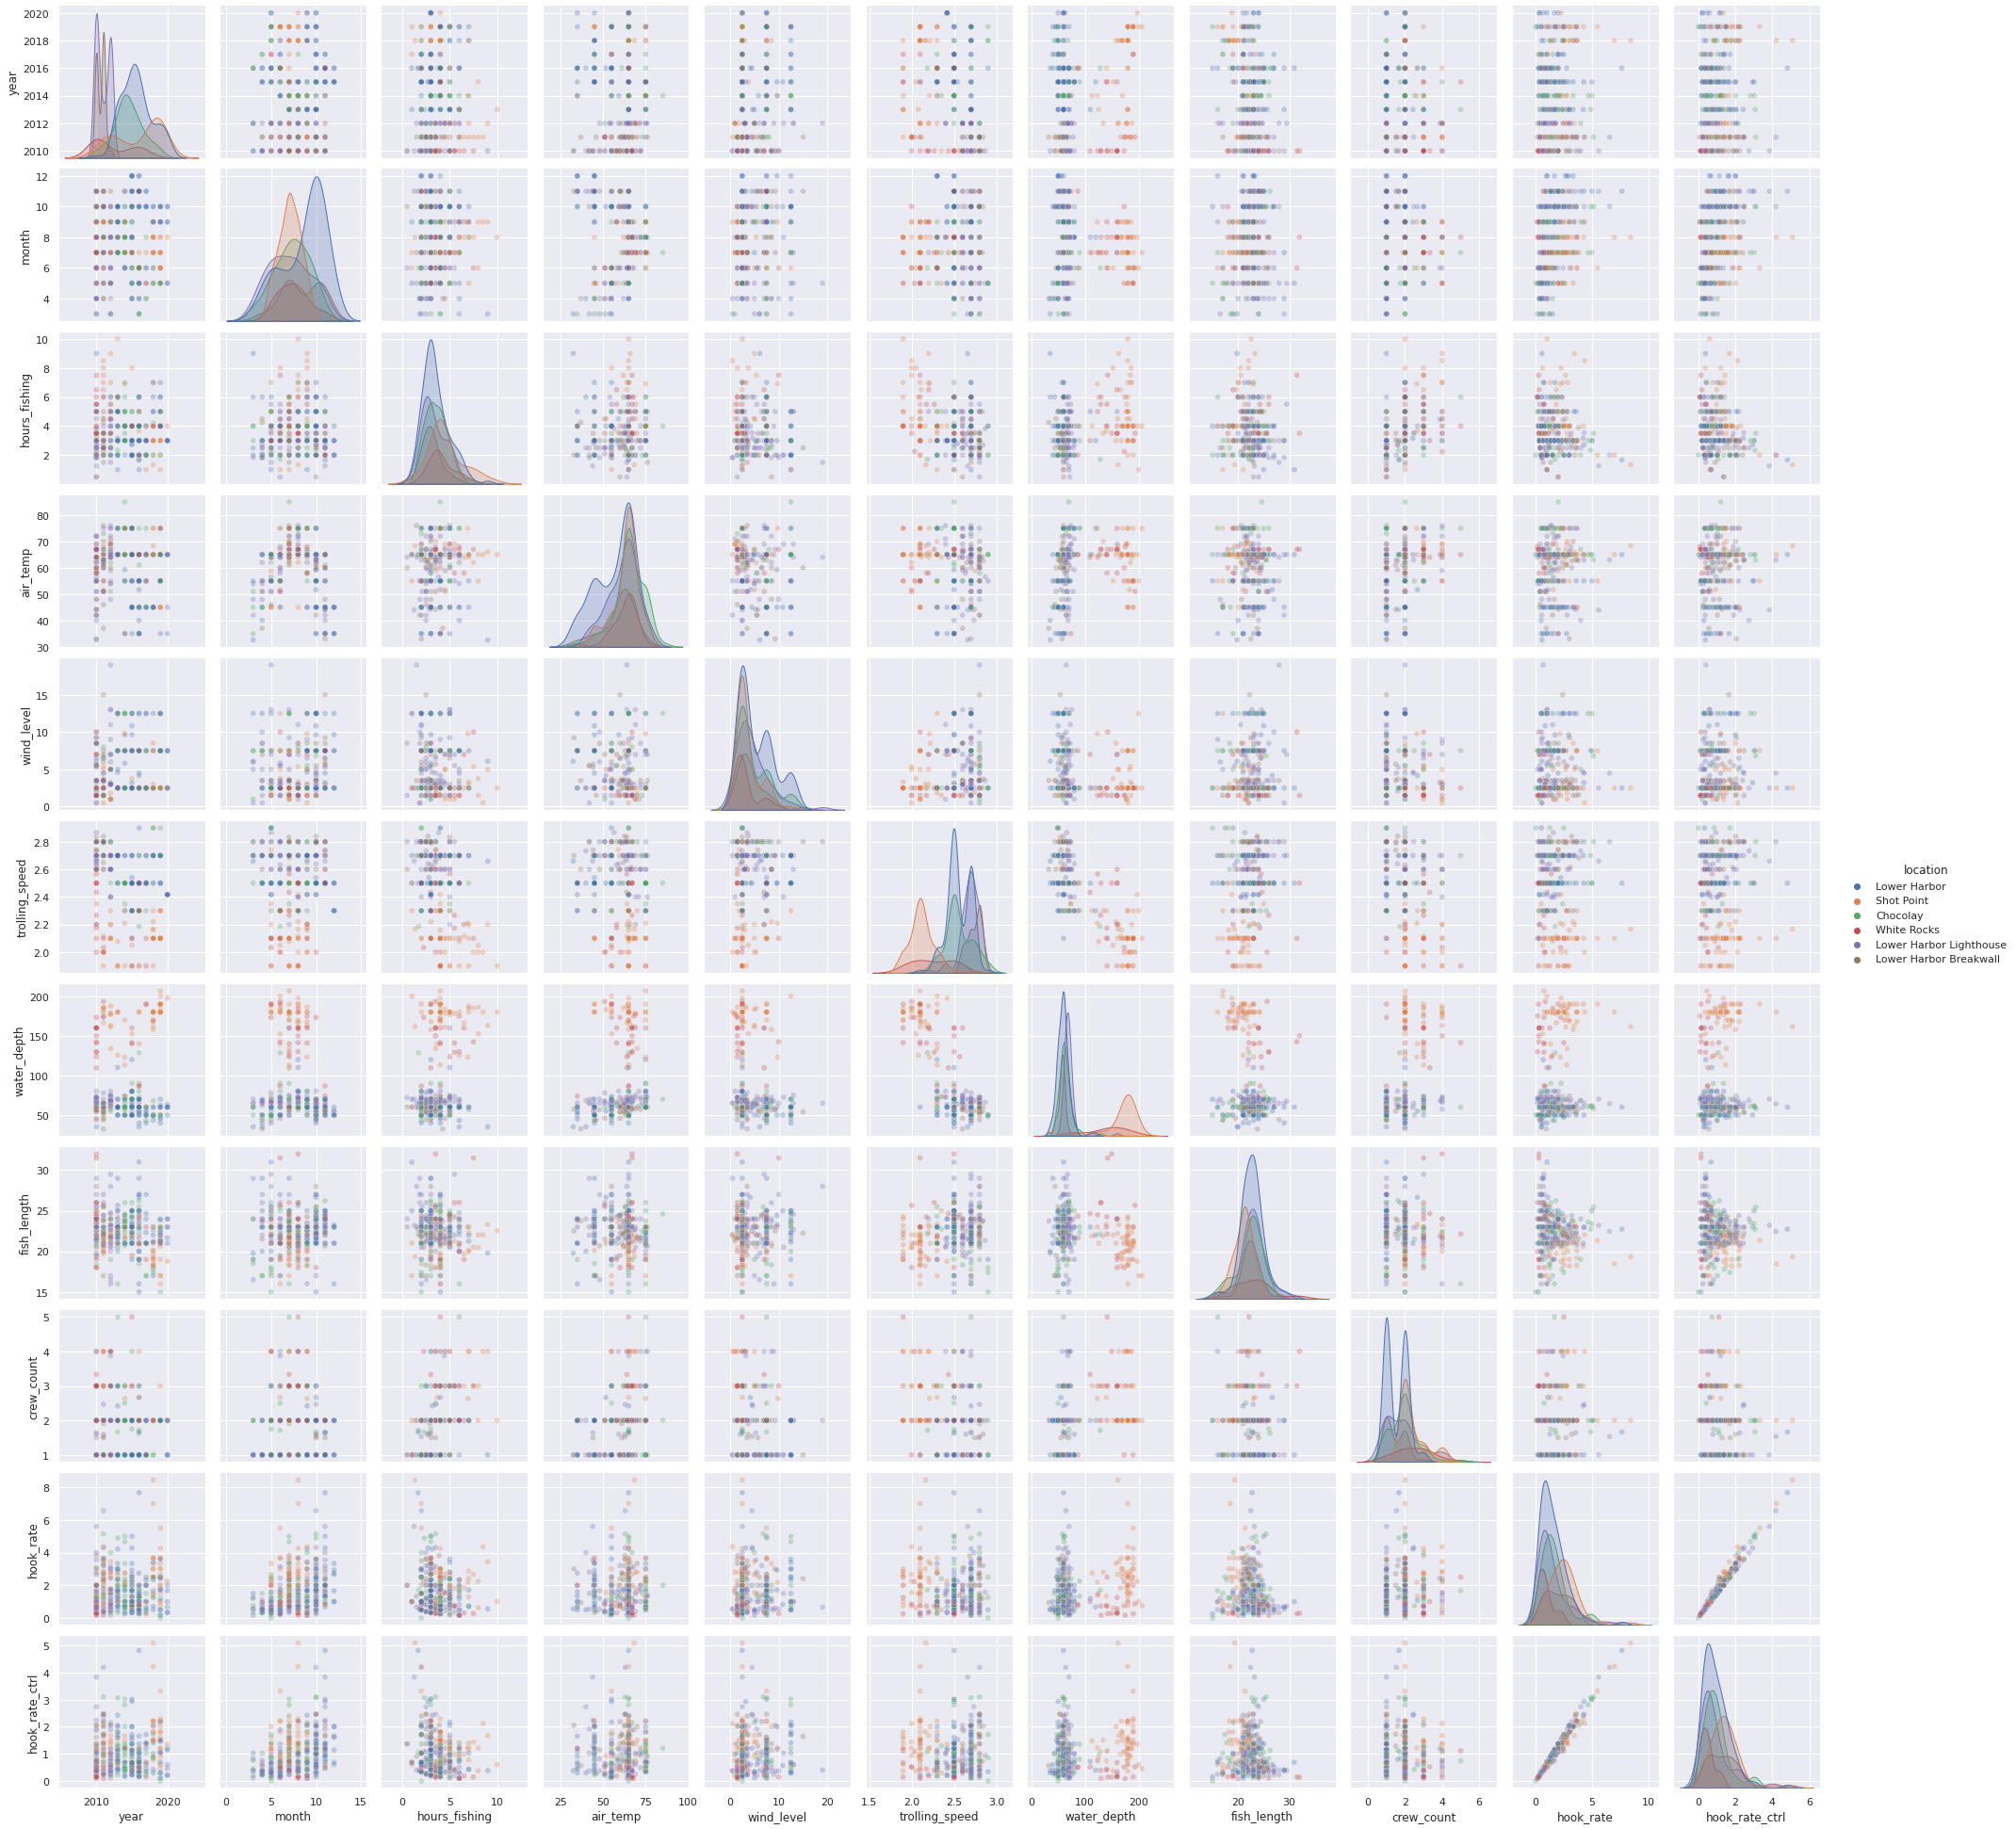

In [ ]:
# Investigate how location interacts with other features

# Only consider locations with atleast 20 samples
mask = fishbd.groupby('location').size() >= 20
mask.value_counts()
fishbd_subset = fishbd
for loc in mask.keys():
    if not mask[loc]:
        fishbd_subset = fishbd_subset[fishbd_subset.location != loc]

# Plot scatterplots colored by location
sns.pairplot(fishbd_subset.drop(columns=['caught', 'hooked']),
                 plot_kws={'alpha': 0.3}, hue='location')

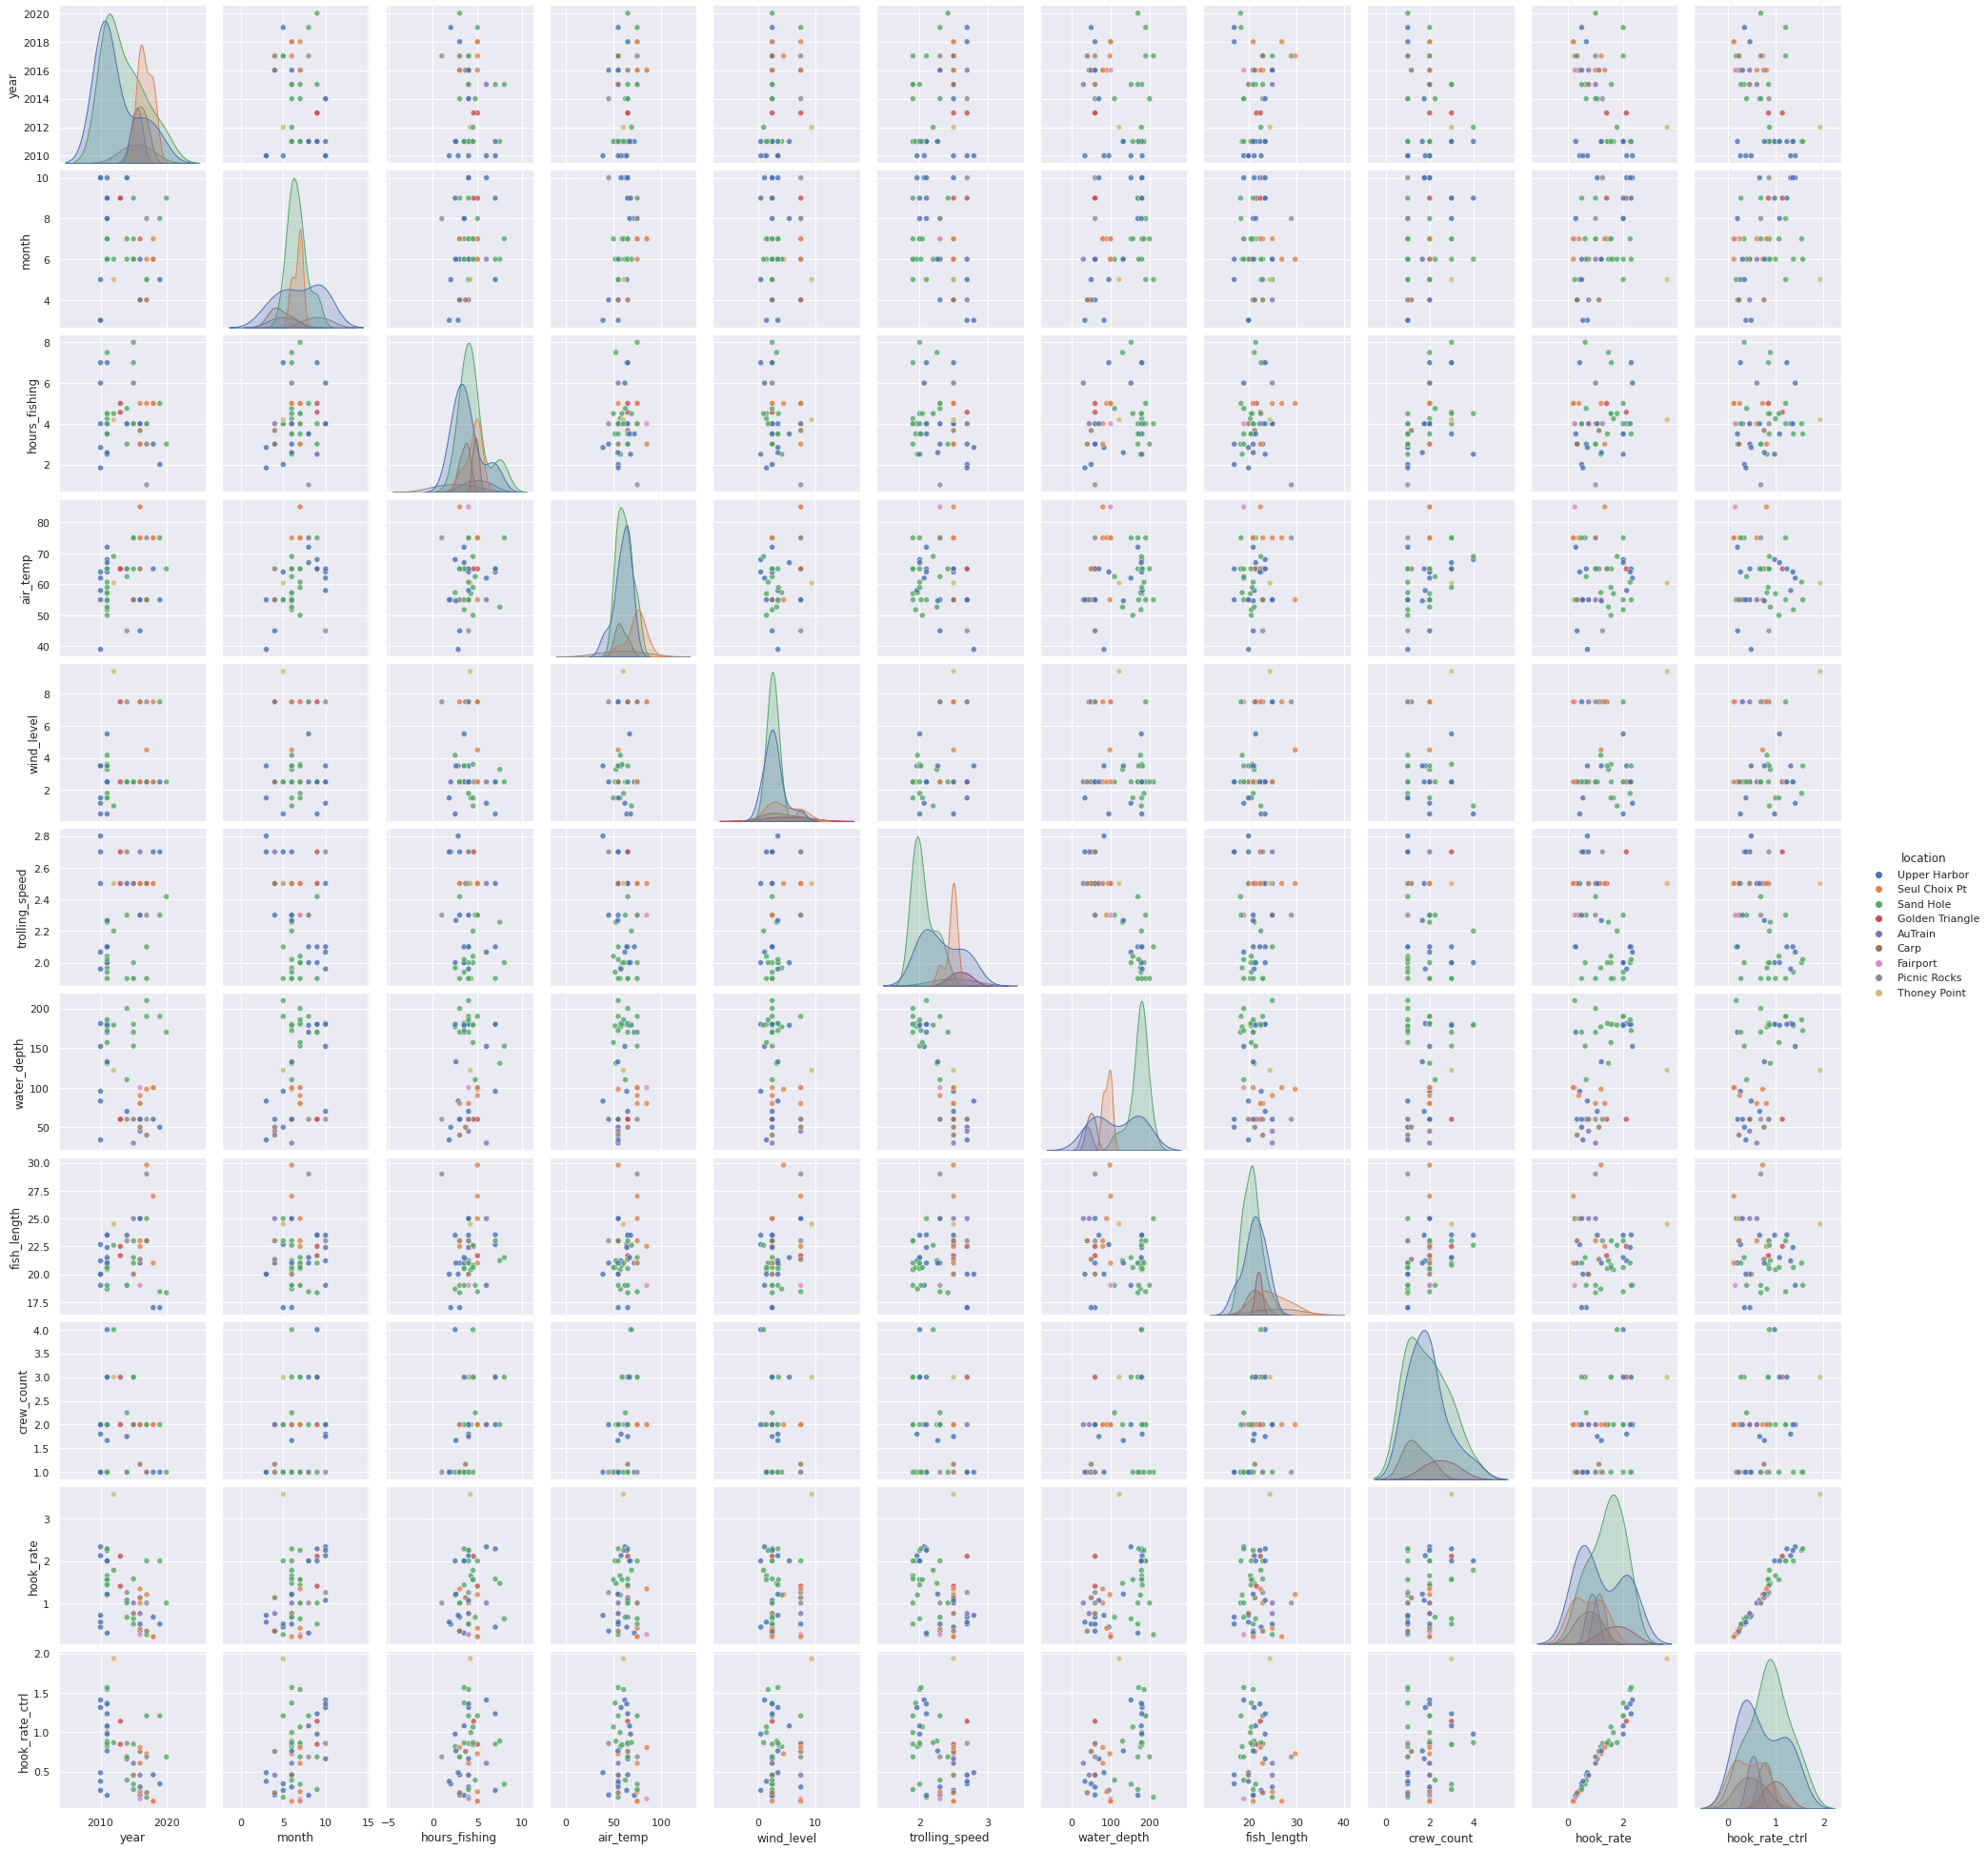

In [ ]:
# Investigate samples we left out

# Only consider locations with less than 20 samples
mask = fishbd.groupby('location').size() < 20
mask.value_counts()
fishbd_subset = fishbd
for loc in mask.keys():
    if not mask[loc]:
        fishbd_subset = fishbd_subset[fishbd_subset.location != loc]

# Plot scatterplots colored by location
sns.pairplot(fishbd_subset.drop(columns=['caught', 'hooked']),
                 plot_kws={'alpha': 0.8}, hue='location')

## Hook rate when controlling for depth and location

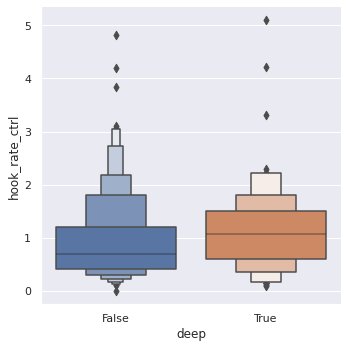

In [ ]:
fishbd['deep'] = fishbd.water_depth > 100
sns.catplot(data=fishbd, x='deep', y='hook_rate_ctrl', kind='boxen')

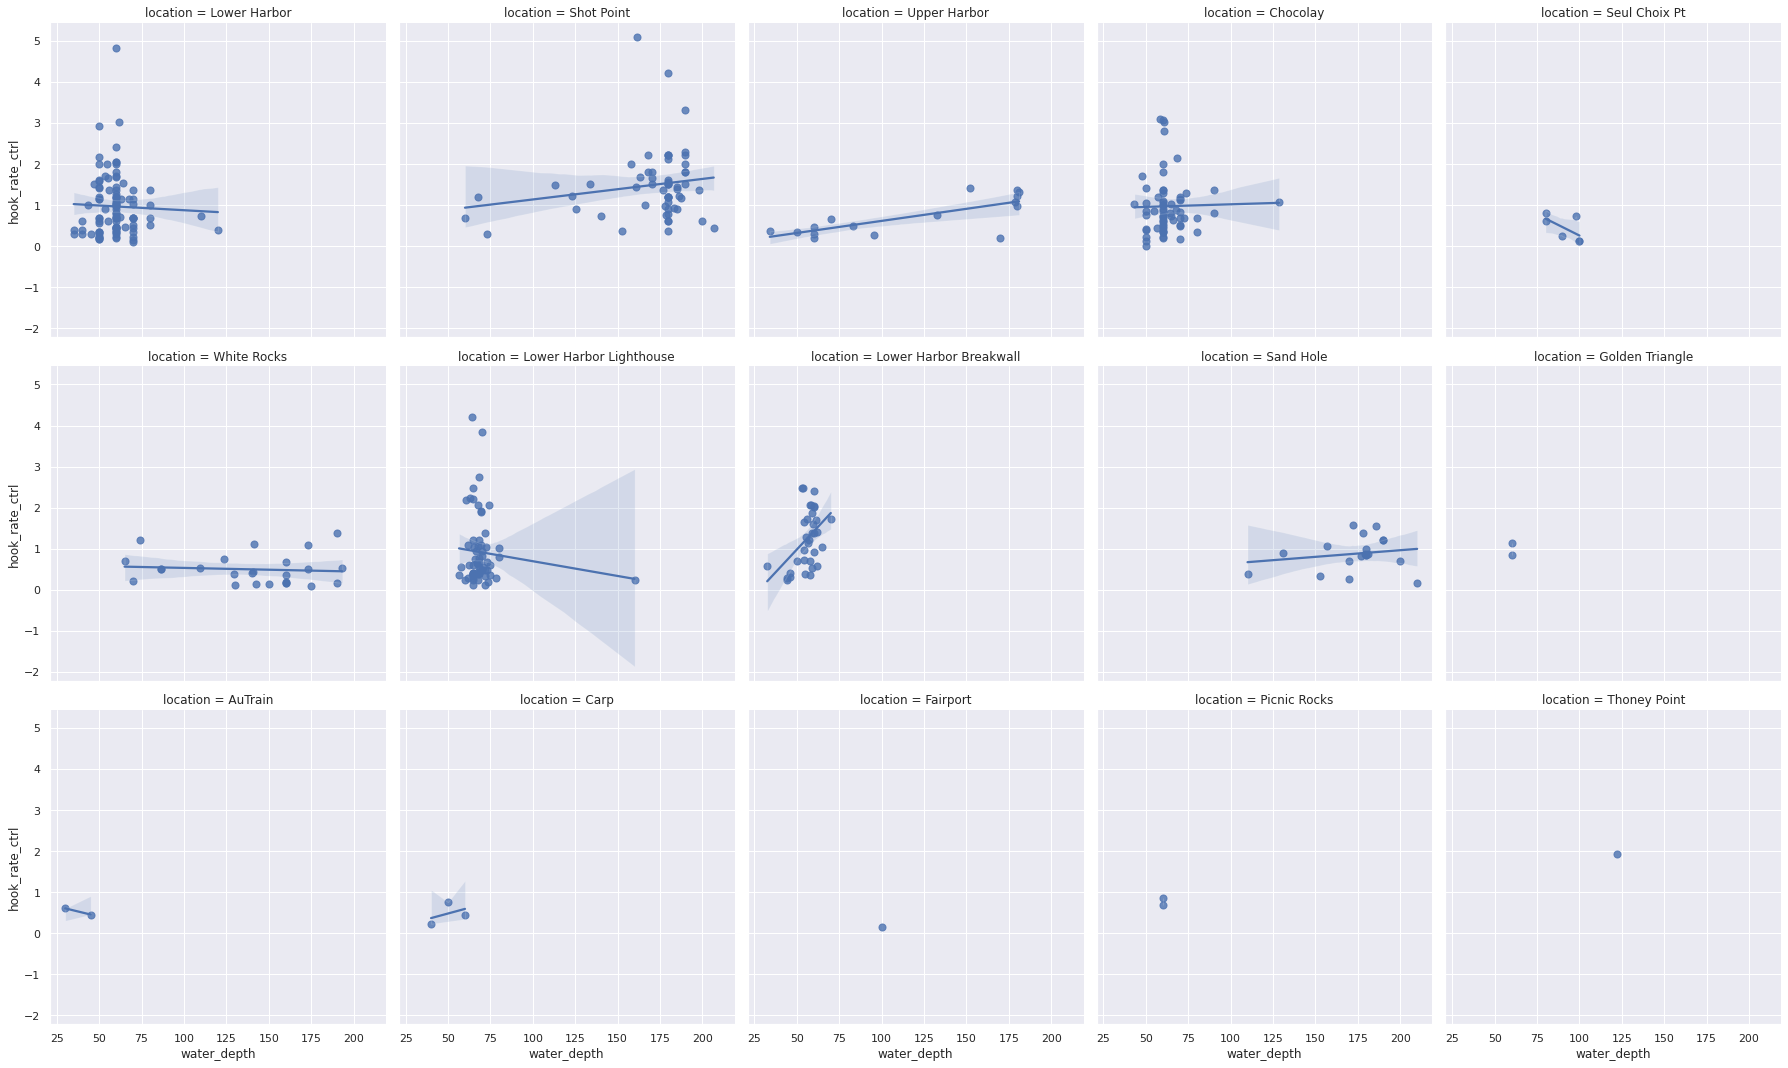

In [ ]:
sns.lmplot(
    data=fishbd, x='water_depth', y='hook_rate_ctrl',
    col='location', col_wrap=5,
    scatter_kws={"s": 50, "alpha": 0.8}, 
)